# Intro




The goal is to create a prototype of algorithm using Keras/tensorflow instead of fastai/pytorch. This will allow me to create my own model and to test those created by other teams.

---
The code is adapted from:

https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/

---
One uses the CovidX dataset from:

https://github.com/lindawangg/COVID-Net

---



In [ ]:
import tensorflow as tf
print('tf version : ' + tf.__version__)

tf version : 2.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


BEWARE: sometimes unziping does'nt work, and then the code won't run! It may be linked to the servers of google colab or the GPU that is automatically selected...

Check the number of files in the folder (compared to the csv file) and be sure that there are no errors during the process...

In [ ]:
# Unzip CovidX-v4 dataset
!unzip -q '/content/drive/My Drive/Colab Notebooks/Internship/COVID19_DATA/Covid-X-v4.zip'

print('Done!')

file #1:  bad zipfile offset (lseek):  0
file #2:  bad zipfile offset (local header sig):  63
file #3:  bad zipfile offset (lseek):  32768
error:  zipfile read error
file #4:  bad zipfile offset (EOF):  39542
error:  zipfile read error
file #5:  bad zipfile offset (EOF):  39610
file #6:  bad zipfile offset (lseek):  401408
file #7:  bad zipfile offset (lseek):  835584
file #8:  bad zipfile offset (lseek):  1236992
file #9:  bad zipfile offset (lseek):  1662976
file #10:  bad zipfile offset (lseek):  2072576
file #11:  bad zipfile offset (lseek):  2539520
file #12:  bad zipfile offset (lseek):  2998272
file #13:  bad zipfile offset (lseek):  3366912
file #14:  bad zipfile offset (lseek):  3776512
file #15:  bad zipfile offset (lseek):  4153344
Done!


We import data

In [ ]:
import pathlib
path = pathlib.Path( '/content/data' )

# Parameters

# Model path
mod_path = '/content/drive/My Drive/Colab Notebooks/Internship/proto1'


# batch size
bs = 128

import pandas as pd
import numpy as np
import keras
from keras_preprocessing.image import ImageDataGenerator
import io

# Paths
path_train = pathlib.Path('/content/data/train/')
path_test = pathlib.Path('/content/data/test/')


# initialize the data and labels
data = []
labels = []

traindf= pd.read_csv(path/"train_split.txt", dtype=str, sep=' ', header=None, names=['Image','Name','Class','Origin']) #.drop('Origin',axis=1).drop('Image',axis=1)
testdf=pd.read_csv(path/"test_split.txt", dtype=str, sep=' ', header=None, names=['Image','Name','Class', 'Origin']) #.drop('Origin',axis=1).drop('Image',axis=1)
 


How is the csv file built?

In [ ]:
traindf

,Image,Name,Class,Origin
0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia,cohen
1,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia,cohen
2,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia,cohen
3,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia,cohen
4,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia,cohen
...,...,...,...,...
13887,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,pneumonia,rsna
13888,c1cddf32-b957-4753-acaa-472ab1447e86,c1cddf32-b957-4753-acaa-472ab1447e86.png,pneumonia,rsna
13889,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,pneumonia,rsna
13890,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,pneumonia,rsna


Now, we create our generator, we create three generator: train, valid and test.

In [ ]:
datagen=ImageDataGenerator(validation_split=0.25) # We split the set
size = 224 # Size of the images

train_generator=datagen.flow_from_dataframe(
  dataframe=traindf,
  directory=path_train,
  x_col='Name',
  y_col='Class',
  subset='training',
  batch_size=bs,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(size,size))

valid_generator=datagen.flow_from_dataframe(
  dataframe=traindf,
  directory=path_train,
  x_col='Name',
  y_col='Class',
  subset='validation',
  batch_size=bs,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(size,size))

test_datagen=ImageDataGenerator()

test_generator=test_datagen.flow_from_dataframe(
  dataframe=testdf,
  directory=path_test,
  x_col='Name',
  y_col=None,
  batch_size=bs,
  shuffle=False, #DO NOT SHUFFLE, otherwise you won't be able to calculate monitors afterward 
  class_mode=None,
  target_size=(size,size))



Found 10419 validated image filenames belonging to 3 classes.
Found 3473 validated image filenames belonging to 3 classes.
Found 1579 validated image filenames.


The indices of each class:

In [ ]:
print(train_generator.class_indices)

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


Our dataset is unbalanced: so we solve it by using class_weights.

In [ ]:
from collections import Counter
labels_count = Counter()

for word in traindf['Class']:
  labels_count[word] += 1

total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in labels_count.items()}



How much images for each classes in the train generator:

In [ ]:
labels_count

Counter({'COVID-19': 468, 'normal': 7966, 'pneumonia': 5458})

The less images we have for one class, the heavier it is:

In [ ]:
class_weights

{'COVID-19': 29.683760683760685,
 'normal': 1.7439116244037158,
 'pneumonia': 2.5452546720410405}

We use indices instead of class names:

In [ ]:
class_weights[train_generator.class_indices['COVID-19']] = class_weights.pop('COVID-19')
class_weights[train_generator.class_indices['normal']] = class_weights.pop('normal')
class_weights[train_generator.class_indices['pneumonia']] = class_weights.pop('pneumonia')

New dictionary:

In [ ]:
class_weights

{0: 29.683760683760685, 1: 1.7439116244037158, 2: 2.5452546720410405}

---
adapted from https://www.kaggle.com/robotdreams/one-cycle-policy-with-keras

---

In [ ]:
# # Implement One Cycle Policy Algorithm in the Keras Callback Class

# from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
# from keras.losses import binary_crossentropy
# from keras.metrics import binary_accuracy
# from keras import backend as K
# from keras.callbacks import *

# class CyclicLR(keras.callbacks.Callback):
    
#     def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
#         self.base_lr = base_lr
#         self.max_lr = max_lr
#         self.base_m = base_m
#         self.max_m = max_m
#         self.cyclical_momentum = cyclical_momentum
#         self.step_size = step_size
        
#         self.clr_iterations = 0.
#         self.cm_iterations = 0.
#         self.trn_iterations = 0.
#         self.history = {}
        
#     def clr(self):
        
#         cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
#         if cycle == 2:
#             x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
#             return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
#         else:
#             x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
#             return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
#     def cm(self):
        
#         cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
#         if cycle == 2:
            
#             x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
#             return self.max_m
        
#         else:
#             x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
#             return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
#     def on_train_begin(self, logs={}):
#         logs = logs or {}

#         if self.clr_iterations == 0:
#             K.set_value(self.model.optimizer.lr, self.base_lr)
#         else:
#             K.set_value(self.model.optimizer.lr, self.clr())
            
#         if self.cyclical_momentum == True:
#             if self.clr_iterations == 0:
#                 K.set_value(self.model.optimizer.momentum, self.cm())
#             else:
#                 K.set_value(self.model.optimizer.momentum, self.cm())
            
            
#     def on_batch_begin(self, batch, logs=None):
        
#         logs = logs or {}
#         self.trn_iterations += 1
#         self.clr_iterations += 1

#         self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
#         self.history.setdefault('iterations', []).append(self.trn_iterations)
        
#         if self.cyclical_momentum == True:
#             self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

#         for k, v in logs.items():
#             self.history.setdefault(k, []).append(v)
        
#         K.set_value(self.model.optimizer.lr, self.clr())
        
#         if self.cyclical_momentum == True:
#             K.set_value(self.model.optimizer.momentum, self.cm())
            

The model:



In [ ]:
# from keras.models import Sequential, save_model, load_model
# from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
# from keras.layers import Conv2D, MaxPooling2D
# from keras import regularizers, optimizers, Model

# from keras.optimizers import Adam, SGD
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# from keras.applications.resnet50 import ResNet50

# # CLR parameters

# epochs = 7
# max_lr = 0.005
# base_lr = max_lr/10
# max_m = 0.98
# base_m = 0.85

# cyclical_momentum = True
# augment = True

# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# # The model we use:
# base_model = ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=None,
#     pooling='avg'
# )
# for layer in base_model.layers:
#     layer.trainable = False

# #change the last layer for the 3 classes
# pred = Dense(3, activation='sigmoid')(base_model.output)
# base_model = Model(inputs=base_model.input, outputs=pred)

# # We implement one cycle policy:
# base_model.compile(loss='binary_crossentropy', optimizer=SGD(0.0000001), metrics=['accuracy'])

# cycles = 2.3
# step = round(STEP_SIZE_TRAIN*cycles)

# clr =  CyclicLR(base_lr=base_lr,
#                 max_lr=max_lr,
#                 step_size=step,
#                 max_m=max_m,
#                 base_m=base_m,
#                 cyclical_momentum=cyclical_momentum)
    
# callbacks = [clr,
#              ModelCheckpoint(filepath='best_model.h5', 
#                               monitor='val_loss',
#                               mode='min',
#                               verbose=1,
#                               save_best_only=True)]

In [ ]:
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers, Model

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from keras.applications.resnet50 import ResNet50

import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """`Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')


class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 1000, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

     

In [ ]:
# # CLR parameters

# epochs = 20

# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# lr_finder = LRFinder()

# # The model we use:
# base_model = ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=None,
#     pooling='avg'
# )
# for layer in base_model.layers:
#     layer.trainable = False

# #change the last layer for the 3 classes
# pred = Dense(3, activation='sigmoid')(base_model.output)
# base_model = Model(inputs=base_model.input, outputs=pred)

# optimizer = tf.keras.optimizers.RMSprop()
# # optimizer = tf.keras.optimizers.Adam(amsgrad=True)
# base_model.compile(optimizer=optimizer, loss='binary_crossentropy')

# base_model.summary()

In [ ]:
# # lr_finder = LRFinder(max_steps=500)

# History = base_model.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=valid_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     class_weight=class_weights, # We change the weights
#                     epochs=epochs,
#                     callbacks=[lr_finder],
#                     verbose = 1)

# import matplotlib.pyplot as plt

# lr_finder.plot()

# # Save the model
# save_model(base_model, mod_path)

Metrics:

In [ ]:
from keras import backend as K
# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def recall(y_true, y_pred):
    """
    Recall metric.
    
    Only computes a batch-wise average of recall.
    
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    
    Only computes a batch-wise average of precision.
    
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

In [ ]:

# CLR parameters
lr = 1e-3
epochs = 10

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

steps = STEP_SIZE_TRAIN * epochs

lr_schedule = OneCycleScheduler(lr, steps)

# The model we use:
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=False, #(224, 224, 3)
    pooling='avg'
)
for layer in base_model.layers:
    layer.trainable = False

#change the last layer for the 3 classes
pred = Dense(3, activation='softmax')(base_model.output) 
base_model = Model(inputs=base_model.input, outputs=pred)

optimizer = tf.keras.optimizers.Adam(lr=lr)

# optimizer = tf.keras.optimizers.Adam(amsgrad=True)
base_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= [precision, recall, f1, 'accuracy']) #, weighted_metrics = class_weights)

base_model.summary()


History = base_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    class_weight=class_weights, # We change the weights
                    epochs=epochs,
                    callbacks=[lr_schedule],
                    verbose = 2)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
print(History.history.keys())

dict_keys(['loss', 'precision', 'recall', 'f1', 'accuracy', 'val_loss', 'val_precision', 'val_recall', 'val_f1', 'val_accuracy'])


# Test

Now we compute all the required metrics

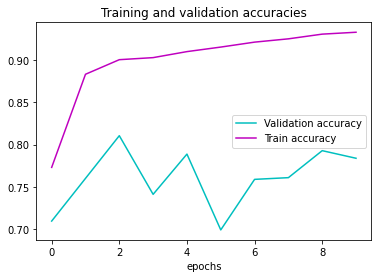

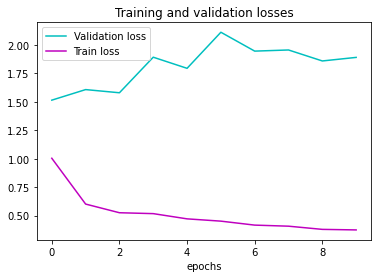

In [ ]:


# # Plot Learning Rate
import matplotlib.pyplot as plt


# plt.plot(clr.history['iterations'], clr.history['lr'])
# plt.xlabel('Training Iterations')
# plt.ylabel('Learning Rate')
# plt.title("One Cycle Policy")
# plt.show()



# Plot losses
val_accuracy = History.history['val_accuracy']
acc = History.history['accuracy']
plt.plot(range(len(val_accuracy)),val_accuracy,'c',label='Validation accuracy')
plt.plot(range(len(acc)),acc,'m',label='Train accuracy')
plt.title('Training and validation accuracies')
plt.legend()
plt.xlabel('epochs')
plt.show()

# Plot losses
val_loss = History.history['val_loss']
loss = History.history['loss']
plt.plot(range(len(val_loss)),val_loss,'c',label='Validation loss')
plt.plot(range(len(loss)),loss,'m',label='Train loss')
plt.title('Training and validation losses')
plt.legend()
plt.xlabel('epochs')
plt.show()

# # Plot momentum
# import matplotlib.pyplot as plt
# plt.plot(clr.history['iterations'], clr.history['momentum'])
# plt.xlabel('Training Iterations')
# plt.ylabel('Momentum')
# plt.title("One Cycle Policy")
# plt.show()

It's time to use our test dataset!

In [ ]:
# Generate predictions for samples
predictions = base_model.predict(test_generator)
print(predictions)

[[1.17905729e-05 9.08960938e-01 9.10272598e-02]
 [4.73870568e-05 4.74338606e-02 9.52518761e-01]
 [1.00399135e-04 1.31833270e-01 8.68066370e-01]
 ...
 [3.25179371e-06 4.48496453e-03 9.95511711e-01]
 [1.36426047e-06 1.69094012e-03 9.98307705e-01]
 [3.64325679e-05 4.75899084e-03 9.95204568e-01]]


In [ ]:
import numpy as np
class_guess = np.argmax(predictions, axis=1)


In [ ]:
label_map = (train_generator.class_indices)
print(label_map)

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


In [ ]:
# adapted from COVIDX-Fastai-XResNet18.ipynb
# Convert dataframe test labels to list
gt = testdf['Class'].tolist()

# Convert from label names to class index values (0, 1, 2)
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
labels = ['COVID-19', 'normal', 'pneumonia']
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels)
test_preds = le.transform( gt )

print("Size of class_guess : " + str(np.size(class_guess)))
print("Size of test_preds : " + str(np.size(np.asarray( test_preds ))))
print("class_guess : " + str(class_guess))
print("test_preds : " + str(test_preds))

# Calculate accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score( class_guess, np.asarray( test_preds ) )
print( "Accuracy = " + str( acc ) )

# Calculate precision per class
print(labels)

from sklearn.metrics import precision_score
prec = precision_score( class_guess, np.asarray( test_preds ), average=None )
print( "Precision (Positive Predictive Value) per class = " + str( prec ))

# Calculate recall per class
from sklearn.metrics import recall_score
rec = recall_score(class_guess, np.asarray(test_preds), average=None )
print( "Recall (Sensitiviy) per class = " + str( rec ))


print('Confusion Matrix')
print(confusion_matrix(np.asarray( test_preds ), class_guess))

Size of class_guess : 1579
Size of test_preds : 1579
class_guess : [1 2 2 ... 2 2 2]
test_preds : [2 2 2 ... 2 2 2]
Accuracy = 0.8562381253958201
['COVID-19', 'normal', 'pneumonia']
Precision (Positive Predictive Value) per class = [0.         0.89830508 0.93771044]
Recall (Sensitiviy) per class = [0.         0.93200469 0.76721763]
Confusion Matrix
[[  0  21  79]
 [  0 795  90]
 [  0  37 557]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
